In [1]:
import os
import os.path as osp
from os.path import abspath, dirname, join
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
import sys
root_folder = os.getcwd()
if not root_folder in sys.path:
    sys.path.append(root_folder)
from dataset.MARTDatasetHelper import MARTDatasetHelper
from dataset.MARTDataProcessor import MARTDataProcessor
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
import numpy as np
import joblib

## Data Loading and Preprocessing

In [2]:
# Initialize folder paths 
# data_path = '/MART/MART-Data' # uncomment this line for Jupyter Lab in Docker environment only
data_path = 'd:\\DCU\\MART\\OUTPUT_MERGED'
mart_dataset_helper = MARTDatasetHelper(data_path)
mart_data_processor = MARTDataProcessor()


In [3]:
# Get initial data needed for training
train_signal_data, test_signal_data = mart_dataset_helper.get_signal_pd_data()
train_labels = mart_dataset_helper.get_train_pd_labels()
# feat_importance_index = sorted([34, 46, 40, 10, 11, 47, 15, 52, 12, 23, 29, 53, 35, 41, 78, 17, 39, 88, 16, 22, 63, 51, 30, 85, 28, 48, 18, 82, 36, 21, 33, 60, 27, 31, 86, 7, 61, 45, 42, 76, 6]) # Magic importance indices!!! WOW!!! 

In [4]:
# Process autographer embedded features of both train and test set to get the main features only for each item in pandas data    
autographer_embedded_train, autographer_embedded_test = mart_dataset_helper.processed_mart_data
train_pd_item_ids, test_pd_item_ids = mart_dataset_helper.get_pd_train_test_item_ids()
autographer_embedded_train = [autographer_embedded_train[item_id]['features'] for item_id in train_pd_item_ids]
autographer_embedded_test = [autographer_embedded_test[item_id]['features'] for item_id in test_pd_item_ids]
autographer_embedded_train = mart_data_processor.get_autographer_mean_embedded_features(autographer_embedded_train)
autographer_embedded_test = mart_data_processor.get_autographer_mean_embedded_features(autographer_embedded_test)

In [5]:
# Impute Missing Values --> JUST FOR FUN!!!
imputed_train_signal_data = np.array(mart_data_processor.fill_pd_missing_values(train_signal_data))
imputed_test_signal_data = np.array(mart_data_processor.fill_pd_missing_values(test_signal_data))

In [17]:
print(len(imputed_train_signal_data[0]), len(autographer_embedded_train[0]))
print(np.concatenate((imputed_train_signal_data[0], autographer_embedded_train[0]), axis=0))

123 512
[ 8.45070423e+01  7.69230769e+01  1.00000000e+02  8.45774947e+01
  3.93311170e+00  9.00000000e+01  4.99875062e-04 -4.73027515e-01
  1.46740755e+00  1.30534600e-03  4.62627787e-02  7.57400000e+03
  1.00000000e-02 -1.90000000e+00  5.40000000e-01  4.52204912e-03
  5.12062314e-02  7.57400000e+03  4.90000000e-01 -1.60000000e+00
  1.52000000e+00  4.89304199e-01  1.02617984e-01  7.57400000e+03
 -8.70000000e-01 -1.56000000e+00  8.40000000e-01 -8.63214946e-01
  8.37915354e-02  7.57400000e+03  1.07917689e-02 -6.65186619e-01
  1.11988207e+00  1.26423339e-02  4.83838729e-02  7.57700000e+03
 -6.80000000e-01 -2.53000000e+00 -4.50000000e-01 -7.30461924e-01
  1.12817460e-01  7.57700000e+03 -1.56000000e+00 -2.40000000e+00
  2.00000000e-02 -1.55944569e+00  8.40070385e-02  7.57700000e+03
 -1.77000000e+00 -2.11000000e+00  9.90000000e-01 -1.78176851e+00
  1.05869142e-01  7.57700000e+03 -1.87191301e-01 -2.16614122e-01
 -7.47291570e-02 -1.82613015e-01  1.84868101e-02  9.00000000e+03
 -9.60586359e-02 

In [7]:
# Comment this block of code if you don't want to add autographer features
len_train, _ = imputed_train_signal_data.shape
len_test, _ = imputed_test_signal_data.shape
train_data = np.array([np.concatenate((imputed_train_signal_data[index], autographer_embedded_train[index]), axis=0) for index in range(len_train)])
test_data = np.array([np.concatenate((imputed_test_signal_data[index], autographer_embedded_test[index]), axis=0) for index in range(len_test)])


In [8]:
X = train_data
Y = np.array(train_labels)

## Try different Machine Learning model to choose appropriate one

In [25]:
# Try ExtraTreesClassifier
extree = ExtraTreesClassifier(n_estimators=250, random_state=0)
scores = cross_val_score(extree, X, Y, cv=14)
extree_mean_score = np.mean(scores)

# Try RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=250, random_state=0)
scores = cross_val_score(rf_clf, X, Y, cv=7)
rf_mean_score = np.mean(scores)

# Try GradientBoostingClassifier
grad_boost_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=0, max_depth=1)
scores = cross_val_score(grad_boost_clf, X, Y, cv=7)
grad_boost_mean_score = np.mean(scores)

# Try AdaBoostClassifier
ada_clf = AdaBoostClassifier(n_estimators=250, random_state=0)
scores = cross_val_score(ada_clf, X, Y, cv=7)
ada_mean_score = np.mean(scores)

In [26]:
print(f"ExtraTreeClassifier Mean Score: {extree_mean_score}")
print(f"RandomForestClassifer Mean Score: {rf_mean_score}")
print(f"GradientBoostingClassifier Mean Score: {grad_boost_mean_score}")
print(f"AdaBoostClassifier Mean Score: {ada_mean_score}")

ExtraTreeClassifier Mean Score: 1.0
RandomForestClassifer Mean Score: 1.0
GradientBoostingClassifier Mean Score: 0.8
AdaBoostClassifier Mean Score: 0.30357142857142855


## TRAINING

In [24]:
scores = []
extree = ExtraTreesClassifier(n_estimators=250, random_state=0)
kfold_cv = KFold(n_splits=7, random_state=42, shuffle=False)
for train_index, test_index in kfold_cv.split(X):
    X_train, X_test, Y_train, Y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
    extree.fit(X_train, Y_train)
    scores.append(extree.score(X_test, Y_test))
print(f"ExtraTreeClassifier Scores: {scores}")
print(f"ExtraTreeClassifier Mean Score: {np.mean(scores)}")

ExtraTreeClassifier Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ExtraTreeClassifier Mean Score: 1.0


## Calculate feature importance for feature selection

Feature ranking:
1. feature 424 (0.004155)
2. feature 246 (0.004015)
3. feature 319 (0.003865)
4. feature 29 (0.003745)
5. feature 326 (0.003651)
6. feature 336 (0.003589)
7. feature 177 (0.003582)
8. feature 453 (0.003534)
9. feature 383 (0.003497)
10. feature 597 (0.003476)
11. feature 249 (0.003428)
12. feature 450 (0.003416)
13. feature 258 (0.003372)
14. feature 187 (0.003341)
15. feature 600 (0.003332)
16. feature 122 (0.003318)
17. feature 479 (0.003312)
18. feature 290 (0.003240)
19. feature 524 (0.003224)
20. feature 252 (0.003223)
21. feature 202 (0.003206)
22. feature 625 (0.003166)
23. feature 244 (0.003152)
24. feature 496 (0.003144)
25. feature 611 (0.003099)
26. feature 274 (0.003085)
27. feature 181 (0.003061)
28. feature 166 (0.003033)
29. feature 588 (0.003028)
30. feature 115 (0.003024)
31. feature 631 (0.003023)
32. feature 306 (0.003016)
33. feature 438 (0.003001)
34. feature 131 (0.002984)
35. feature 119 (0.002975)
36. feature 493 (0.002969)
37. feature 393 (0.00

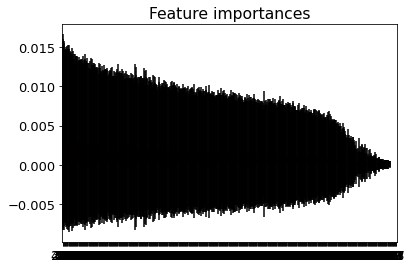

In [12]:
importances = extree.feature_importances_
std = np.std([tree.feature_importances_ for tree in extree.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [13]:
feature_importances_index = []
for f in range(X.shape[1]):
    # print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    if importances[indices[f]] >= 0.01:
        feature_importances_index.append(indices[f])
print(feature_importances_index)

[]


## Infer prediction and output submission file

In [14]:
X_test = test_data
Y_prob = extree.predict_proba(X_test)
mart_dataset_helper.dump_test_result(Y_prob, 'TU_ImagePlusSignal.txt')
joblib.dump(Y_prob, 'TU_ImagePlusSignal.joblib')

['TU_ImagePlusSignal.joblib']